In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra 
import selector as se

In [3]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [4]:
rho = 1.
num_points = 10
eps_sublevel = percent = 0.1

num_agents = num_packages = 200
num_fcs = 50

filename = "subgrad_ap_N%d_%.2f_n%d_m%d"%(num_points, eps_sublevel, num_agents, num_fcs)

In [5]:
econ, A_ineq, b_ineq = mra.ap_data(num_packages, num_fcs)

In [6]:
b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [7]:
true_xp, true_xf, true_f, true_lamb, true_prob = mra.assignment_problem_milp_solution(num_packages, num_fcs, econ, eps=0, integer=False)
print(f"{true_f=}")

true_f=-90.29596235239258


In [7]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

0.12754546028411598

In [8]:
true_lamb.shape, true_xp.size + true_xf.size

((50,), 10050)

In [9]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_packages):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.cvx_package_agent_query_multiple_actions(lamb_k, i, num_fcs,
                                                                                  econ, eps_sublevel=eps_sublevel, K=K, eps=0, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.cvx_package_agent_query_multiple_actions_noisy_prices(lamb_k, i, num_fcs,
                                                                                  econ, percent=percent, K=K, eps=0, return_best=True)]
 
for i in range(num_packages, num_packages+num_fcs):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.fc_agent_query_multiple_actions(lamb_k, i-num_packages, 
                                                                          econ, eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.fc_agent_query_multiple_actions_noisy_prices(lamb_k, i-num_packages, 
                                                                          econ, percent=percent, K=K, return_best=True)]


fun_obj_val = lambda x_k: mra.assignment_problem_obj_val(x_k, num_packages, num_fcs, econ, integer=False)

# Dual subgradient

In [10]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

### Best learning schedule

In [ ]:
alpha_ks = ["0.1/sqrt(k)", "1/sqrt(k)", "1/k", "10/k"]
func_alphas = {"0.1/sqrt(k)": lambda k: 0.1 / np.sqrt(k+1), 
               "1/sqrt(k)": lambda k: 1 / np.sqrt(k+1),
               "1/k": lambda k: 1 / (k+1),
               "10/k": lambda k: 10 / (k+1)}

best_schedule = [np.inf, "0.1/sqrt(k)"] 

for alpha_k, func_alpha_k in func_alphas.items():
    print(f"{alpha_k=}")
    all_results = mra.dual_proj_subgradient(fun_agents_eps, fun_obj_val, primal_var_size,
                                                             func_alpha_k, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=1, num_iters=20, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]

    if all_results["viol_primal_paver_xk"][-1] < best_schedule[0]:
        best_schedule = [all_results["viol_primal_paver_xk"][-1], alpha_k]

alpha_k='0.1/sqrt(k)'


/Users/tepars/Documents/postdoc/mra_precovery/mra/subgrad.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.3026E+00,  viol_xk=1.3706E+02, viol_mra=1.3706E+02, lamb_rel_diff=INF
epoch=19, f_subopt_xk=5.2437E-02,  f_subopt_mra=5.2437E-02,  viol_xk=9.4832E+01, viol_mra=9.4832E+01, lamb_rel_diff=5.3704E-02
alpha_k='1/sqrt(k)'
epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.3026E+00,  viol_xk=1.3706E+02, viol_mra=1.3706E+02, lamb_rel_diff=INF
epoch=19, f_subopt_xk=6.8195E-01,  f_subopt_mra=6.8195E-01,  viol_xk=4.5482E+02, viol_mra=4.5482E+02, lamb_rel_diff=7.8129E-01
alpha_k='1/k'
epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.3026E+00,  viol_xk=1.3706E+02, viol_mra=1.3706E+02, lamb_rel_diff=INF
epoch=19, f_subopt_xk=1.1442E-01,  f_subopt_mra=1.1442E-01,  viol_xk=1.6017E+02, viol_mra=1.6017E+02, lamb_rel_diff=2.0212E-01
alpha_k='10/k'
epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.3026E+00,  viol_xk=1.3706E+02, viol_mra=1.3706E+02, lamb_rel_diff=INF
epoch=19, f_subopt_xk=8.3070E-01,  f_subopt_mra=8.3070E-01,  viol_xk=3.8794E+02, viol_mra=3.87

In [12]:
best_alpha_k = best_schedule[1]
print(f"{best_alpha_k=}")
func_alpha_k = func_alphas[best_alpha_k]

best_alpha_k='0.1/sqrt(k)'


In [ ]:
all_results_eps, lamb_k_eps, _, x_k, _, mra_xk_eps  = mra.dual_proj_subgradient(fun_agents_eps, fun_obj_val, primal_var_size, func_alpha_k, 
                                                                                             A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)


all_results_noisy_y, lamb_k_eps, _, x_k, _, mra_xk_noisy_y  = mra.dual_proj_subgradient(fun_agents_noisy_y, fun_obj_val, primal_var_size, func_alpha_k, 
                                                                                             A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=100, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)

epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.0444E+00,  viol_xk=1.3706E+02, viol_mra=1.0278E+02, lamb_rel_diff=INF
epoch=22, f_subopt_xk=4.9120E-02,  f_subopt_mra=3.7069E-02,  viol_xk=9.8802E+01, viol_mra=8.4199E-10, lamb_rel_diff=4.9997E-02
terminate with lamb_rel_diff=0.049996790318860965
epoch=0, f_subopt_xk=1.3026E+00,  f_subopt_mra=1.2536E+00,  viol_xk=1.3706E+02, viol_mra=1.3244E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=2.8606E-02,  f_subopt_mra=1.9131E-02,  viol_xk=7.1769E+01, viol_mra=6.9481E-01, lamb_rel_diff=2.5343E-02
epoch=87, f_subopt_xk=1.8505E-02,  f_subopt_mra=1.1371E-02,  viol_xk=5.6414E+01, viol_mra=2.5041E-10, lamb_rel_diff=1.8529E-02
terminate with lamb_rel_diff=0.01852915752685645


In [14]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

T=100
0.018505396150045324 sub_eps 0.037068795761586615 noisy_y 0.011371164286800866 proj 0.7852906092715525


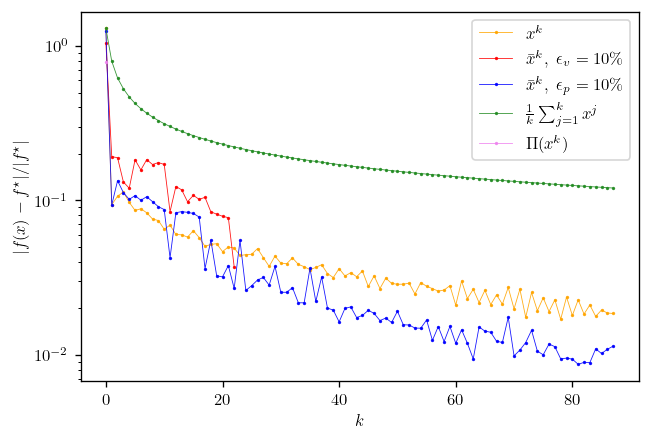

In [15]:
mra.plot_func_subopt_all(all_res, all_results_eps, all_results_noisy_y, true_f, eps_sublevel, percent, 
                        filename=filename, T=100)

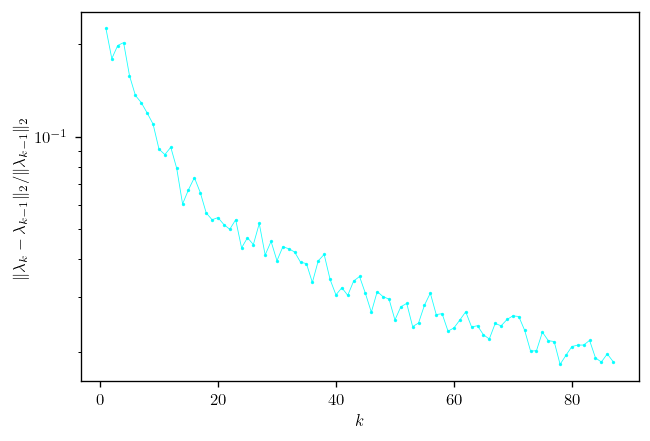

In [16]:
mra.plot_lamb_k_diff(all_res, filename)

In [17]:
print(np.array(all_res["viol_primal_xk"])[-1],
      "sub_eps", np.array(all_results_eps["viol_primal_mra_xk"])[-1],
      "noisy_y", np.array(all_results_noisy_y["viol_primal_mra_xk"])[-1])

23.118255574560756 sub_eps 4.789663320906717e-10 noisy_y 1.4703142724453236e-10


In [18]:
print("sub_eps", np.array(all_results_eps["viol_primal_mra_xk"]).size,
      "noisy_y", np.array(all_results_noisy_y["viol_primal_mra_xk"]).size)

sub_eps 23 noisy_y 88


T=100
23.118255574560756 sub_eps 4.789663320906717e-10 noisy_y 1.4703142724453236e-10


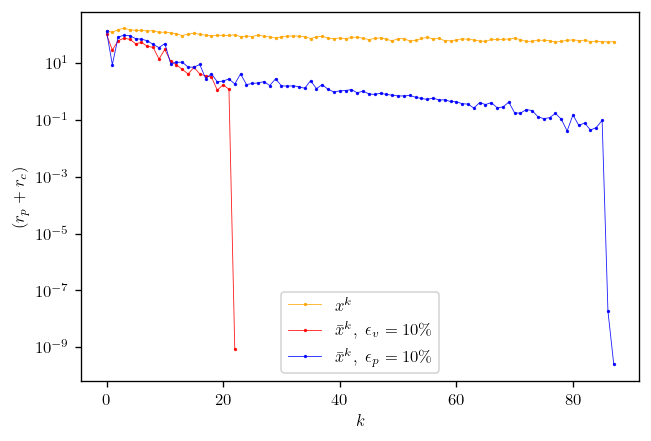

In [19]:
mra.plot_prim_complem_residuals(all_res, all_results_eps, all_results_noisy_y, b_norm, eps_sublevel, percent, 
                               filename=filename, T=100)

T=100
23.118255574560756 sub_eps 4.789663320906717e-10 noisy_y 1.4703142724453236e-10


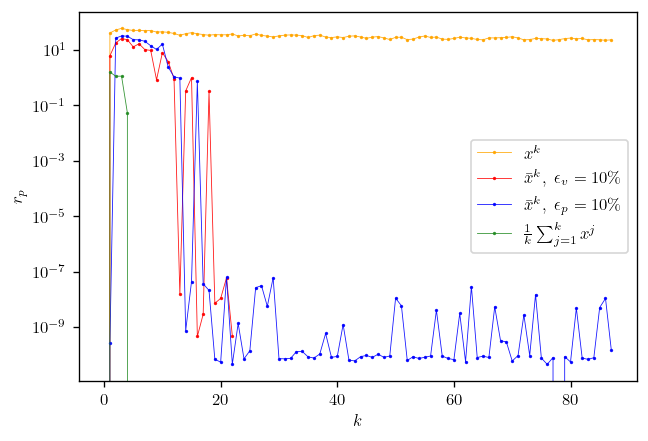

In [20]:
mra.plot_prim_residuals(all_res, all_results_eps, all_results_noisy_y, b_norm, eps_sublevel, percent, 
                       filename=filename, T=100)

T=100


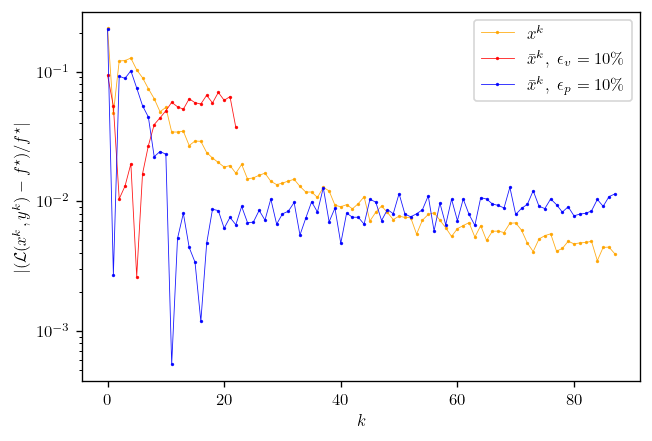

In [21]:
mra.plot_lagr_subopt_all(all_res, all_results_eps, all_results_noisy_y, eps_sublevel, percent, true_f=true_f,
                        filename=filename, T=100)

In [8]:
import pickle

with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)

all_results_noisy_y = res["noisy_y"]
all_res = all_results_eps = res["eps"]

if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

In [16]:
T = 100
idx_xk = np.argmin(np.array(all_res["viol_primal_xk"])[:T]) 
idx_paverage = 20#np.argmin(np.array(all_res["viol_primal_paver_xk"])[1:T])+1
idx_noisy_y = 20#np.where(np.array(all_results_noisy_y["viol_primal_mra_xk"][2:T]) < 1e-8)[0][0] + 2
idx_eps = np.where(np.array(all_results_eps["viol_primal_compl_mra_xk"][1:T]) < 1e-8)[0][0] + 1

print(f"{idx_xk=}, {idx_eps=}, {idx_noisy_y=}, {idx_paverage=}")

print("xk", (np.abs(np.array(all_res["f_xk"]) - true_f)/np.abs(true_f))[idx_xk],
    "sub_eps", (np.abs(np.array(all_results_eps["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_eps],
    "noisy_y", (np.abs(np.array(all_results_noisy_y["f_mra_xk"]) - true_f)/np.abs(true_f))[idx_noisy_y],
    "proj", ((np.abs(np.array(all_res["f_proj_xk"]) - true_f))/np.abs(true_f)).min(),
    "paverage", (np.abs(np.array(all_res["f_paver_xk"]) - true_f)/np.abs(true_f))[idx_paverage])

print("xk", np.array(all_res["viol_primal_xk"])[idx_xk],
      "sub_eps", all_results_eps["viol_primal_mra_xk"][idx_eps],
      "noisy_y", all_results_noisy_y["viol_primal_mra_xk"][idx_noisy_y],
      "paverage", np.array(all_res["viol_primal_paver_xk"])[idx_paverage])

idx_xk=0, idx_eps=22, idx_noisy_y=20, idx_paverage=20
xk 1.3025673032606528 sub_eps 0.037068795761586615 noisy_y 0.03195671107390458 proj 0.7852906092715525 paverage 0.23150220575939323
xk 0.0 sub_eps 4.789663320906717e-10 noisy_y 5.5339482498991726e-11 paverage 0.0


In [23]:
import pickle

with open(f"../results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
with open(f"../results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
# res["eps"].keys()

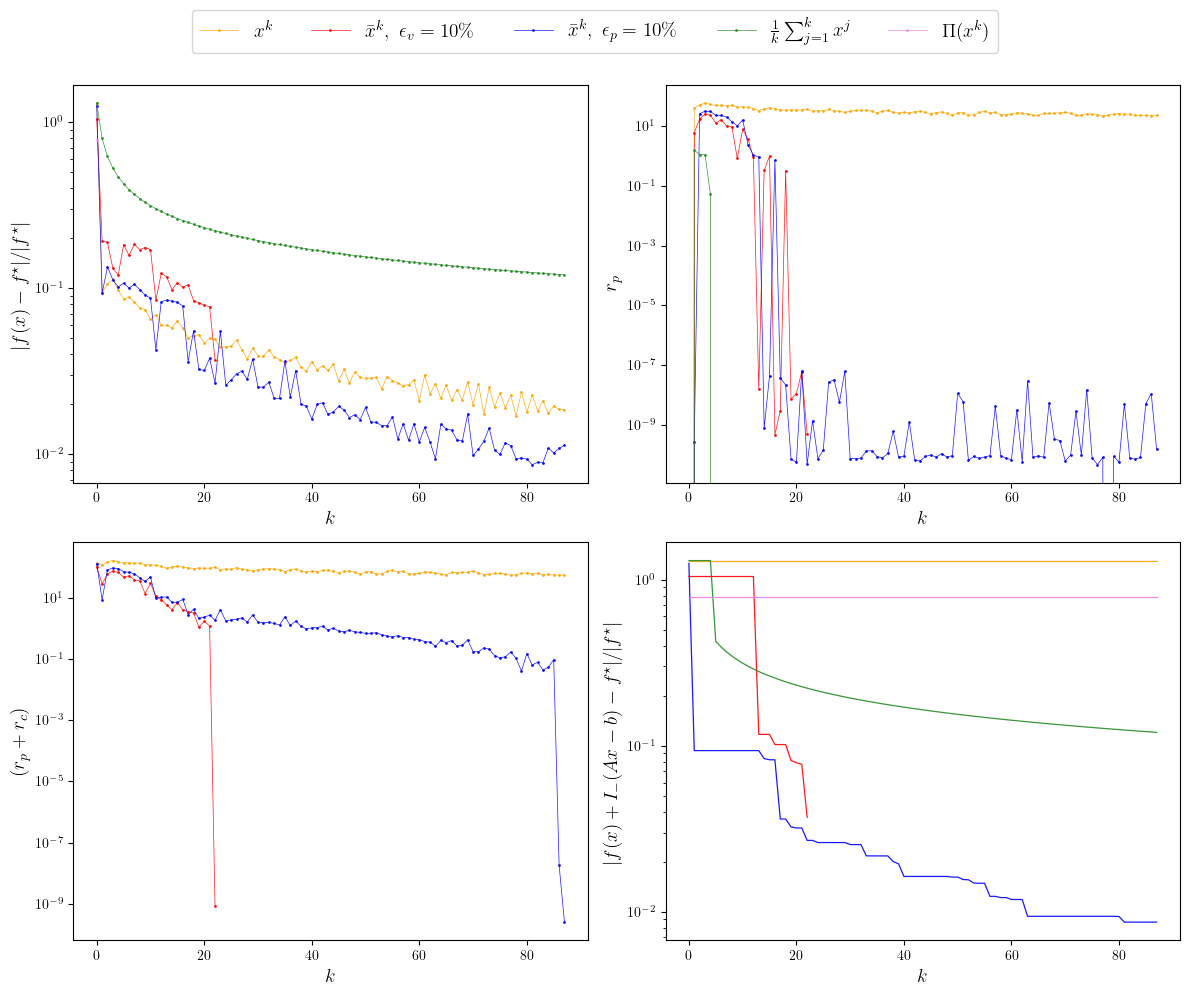

In [24]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, filename, T)